# (1 of 1) Clustering
---
# Customer Segmentation
# Clustering : K-Means, Hierarchical
---

### We will segment customers based on their buying behavior.
by using K-Means, Hierarchical Clustering.

In [1]:
import sys
sys.version

'3.8.8 (default, Apr 13 2021, 19:58:26) \n[GCC 7.3.0]'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

---
# Data Cleaning and EDA
---

In [3]:
df = pd.read_csv('./dataset/Online Retail.csv')

In [4]:
df.head(15)

InvoiceNo StockCode                          Description  Quantity  \
0     536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365     71053                  WHITE METAL LANTERN         6   
2     536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3     536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
5     536365     22752         SET 7 BABUSHKA NESTING BOXES         2   
6     536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER         6   
7     536366     22633               HAND WARMER UNION JACK         6   
8     536366     22632            HAND WARMER RED POLKA DOT         6   
9     536367     84879        ASSORTED COLOUR BIRD ORNAMENT        32   
10    536367     22745           POPPY'S PLAYHOUSE BEDROOM          6   
11    536367     22748            POPPY'S PLAYHOUSE KITCHEN         6   
12    536367     22749    FELTCRAFT PRINCESS CHARLOTTE DOLL         8   
13    536367     22310              IVORY KNITTED MUG COSY          6   
14    536367     84969   BOX OF 6 ASSORTED COLOUR TEASPOONS         6   

         InvoiceDate  UnitPrice  CustomerID         Country  
0   01/12/2010 08:26       2.55     17850.0  United Kingdom  
1   01/12/2010 08:26       3.39     17850.0  United Kingdom  
2   01/12/2010 08:26       2.75     17850.0  United Kingdom  
3   01/12/2010 08:26       3.39     17850.0  United Kingdom  
4   01/12/2010 08:26       3.39     17850.0  United Kingdom  
5   01/12/2010 08:26       7.65     17850.0  United Kingdom  
6   01/12/2010 08:26       4.25     17850.0  United Kingdom  
7   01/12/2010 08:28       1.85     17850.0  United Kingdom  
8   01/12/2010 08:28       1.85     17850.0  United Kingdom  
9   01/12/2010 08:34       1.69     13047.0  United Kingdom  
10  01/12/2010 08:34       2.10     13047.0  United Kingdom  
11  01/12/2010 08:34       2.10     13047.0  United Kingdom  
12  01/12/2010 08:34       3.75     13047.0  United Kingdom  
13  01/12/2010 08:34       1.65     13047.0  United Kingdom  
14  01/12/2010 08:34       4.25     13047.0  United Kingdom

In [5]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d/%m/%Y %H:%M')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
df.describe()

Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000

There are rows where Quantity and UnitPrice are negative.  

At first, I assumed that customers might place an order and then cancel it, so they might have to input negative values to deduct the balance. Then, I investigated the CustomerID to find out if my assumption was correct. Eventually, I discovered that this assumption is not true.

However, I am still unsure what the negative values mean, so I will remove rows where Quantity and UnitPrice are negative.

In [8]:
df = df[df['Quantity']>=0]

In [9]:
df = df[df['UnitPrice']>=0]

Find the total sum of each invoice.

In [10]:
df['TotalSum'] = df['Quantity']*df['UnitPrice']

Count the number of invoices for each person.

In [11]:
invoice_cnt = df.groupby('CustomerID')['InvoiceNo'].nunique()
invoice_cnt.rename('InvoiceCount',inplace=True)

CustomerID
12346.0     1
12347.0     7
12348.0     4
12349.0     1
12350.0     1
           ..
18280.0     1
18281.0     1
18282.0     2
18283.0    16
18287.0     3
Name: InvoiceCount, Length: 4339, dtype: int64

Use the latest date in the dataset as a reference point to create the "snapshot_date" column.  
It will be used in the "Recentness" calculation.

In [12]:
import datetime

In [13]:
snapshot_date = max(df['InvoiceDate'])

Concatenate the DataFrames.

In [14]:
tmp = df.groupby('CustomerID').agg({
    'TotalSum':'sum',
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days
})

df_real = pd.concat([tmp,invoice_cnt],axis=1)
df_real.rename(columns={'InvoiceDate':'Recentness'},inplace=True)
df_real

TotalSum  Recentness  InvoiceCount
CustomerID                                    
12346.0     77183.60         325             1
12347.0      4310.00           1             7
12348.0      1797.24          74             4
12349.0      1757.55          18             1
12350.0       334.40         309             1
...              ...         ...           ...
18280.0       180.60         277             1
18281.0        80.82         180             1
18282.0       178.05           7             2
18283.0      2094.88           3            16
18287.0      1837.28          42             3

[4339 rows x 3 columns]

In [15]:
df_real.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4339 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TotalSum      4339 non-null   float64
 1   Recentness    4339 non-null   int64  
 2   InvoiceCount  4339 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 135.6 KB


In [16]:
df_real.describe()

TotalSum   Recentness  InvoiceCount
count    4339.000000  4339.000000   4339.000000
mean     2053.793018    91.518322      4.271952
std      8988.248381   100.009747      7.705493
min         0.000000     0.000000      1.000000
25%       307.245000    17.000000      1.000000
50%       674.450000    50.000000      2.000000
75%      1661.640000   141.000000      5.000000
max    280206.020000   373.000000    210.000000

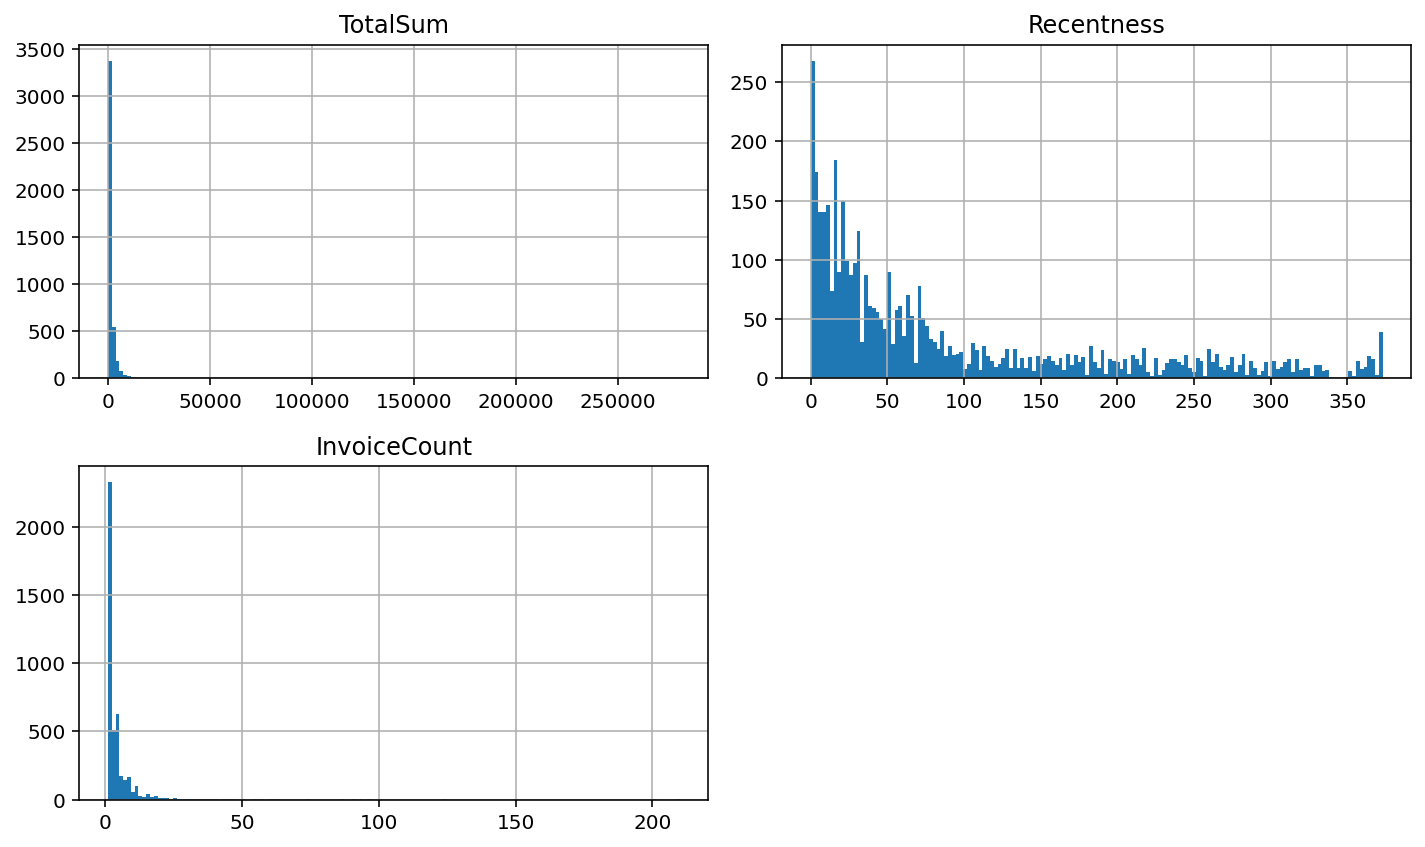

In [17]:
df_real.hist(bins=150, figsize=(10,6))
plt.tight_layout()

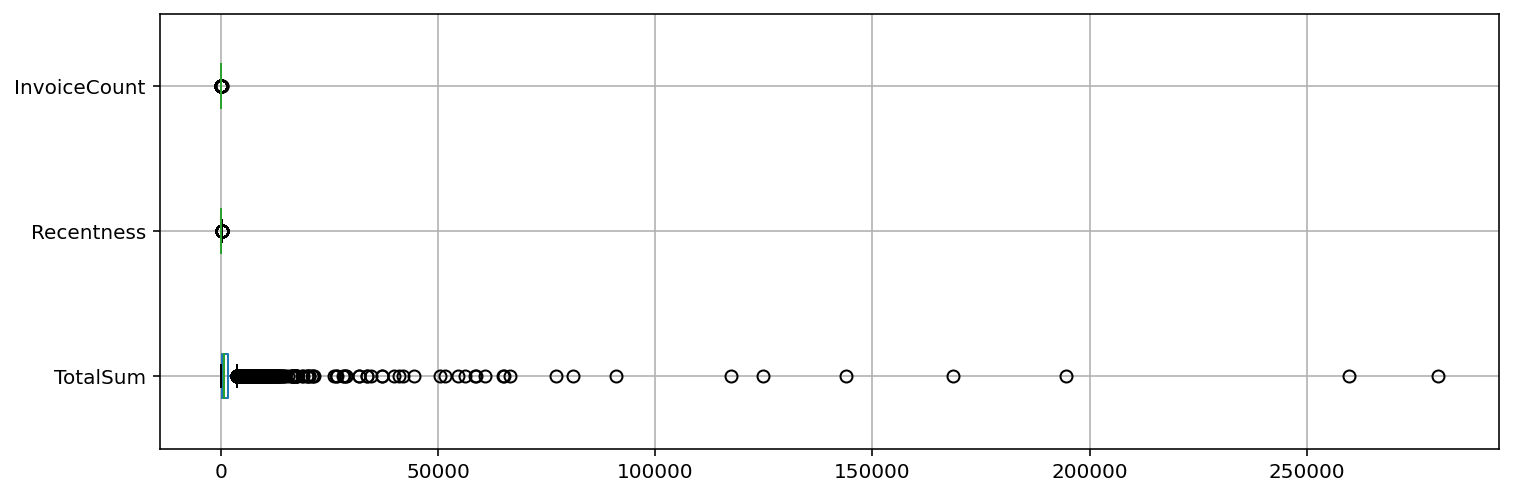

In [18]:
df_real.boxplot(vert=False, figsize=(12,4))
plt.show()

### Filter out the outliers

In [19]:
df_real = df_real[df_real['TotalSum']<25000].copy()

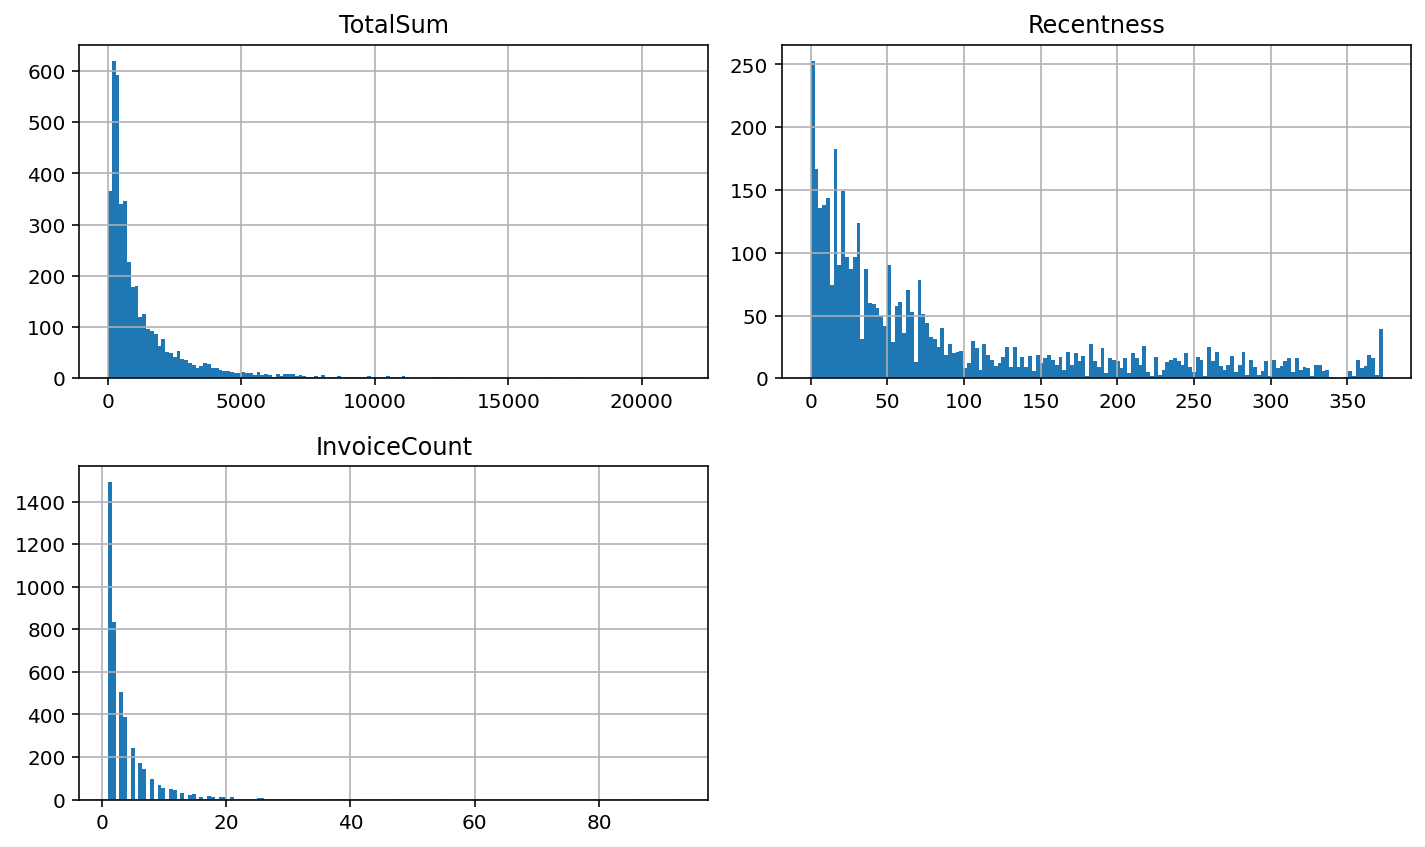

In [20]:
df_real.hist(bins=150, figsize=(10,6))
plt.tight_layout()

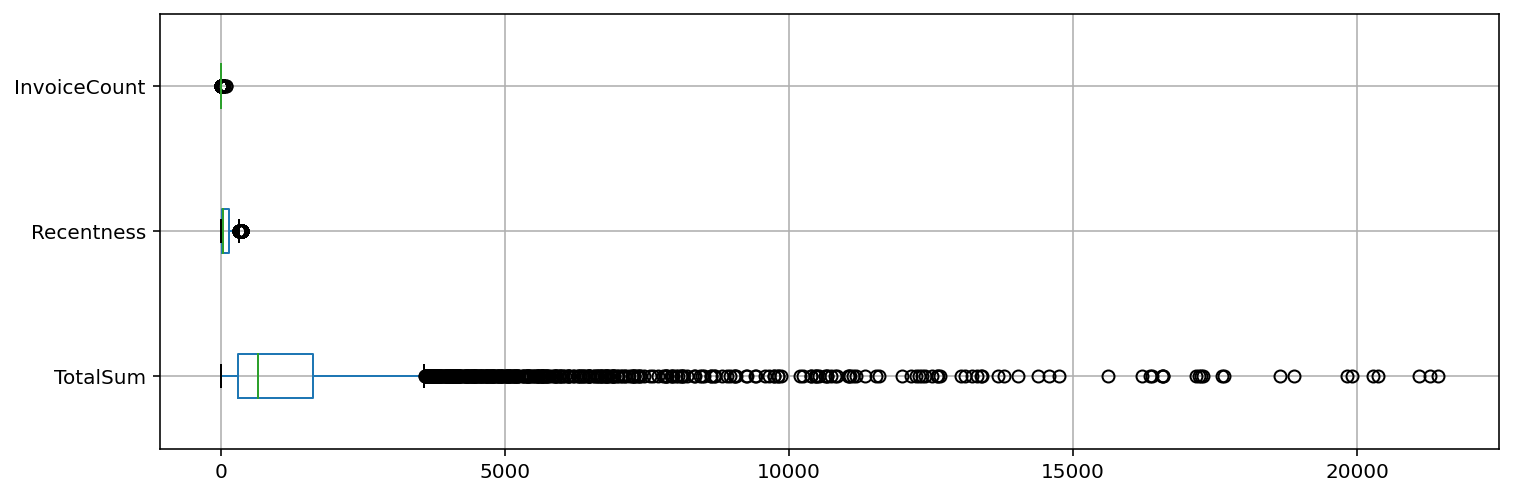

In [21]:
df_real.boxplot(vert=False, figsize=(12,4))
plt.show()

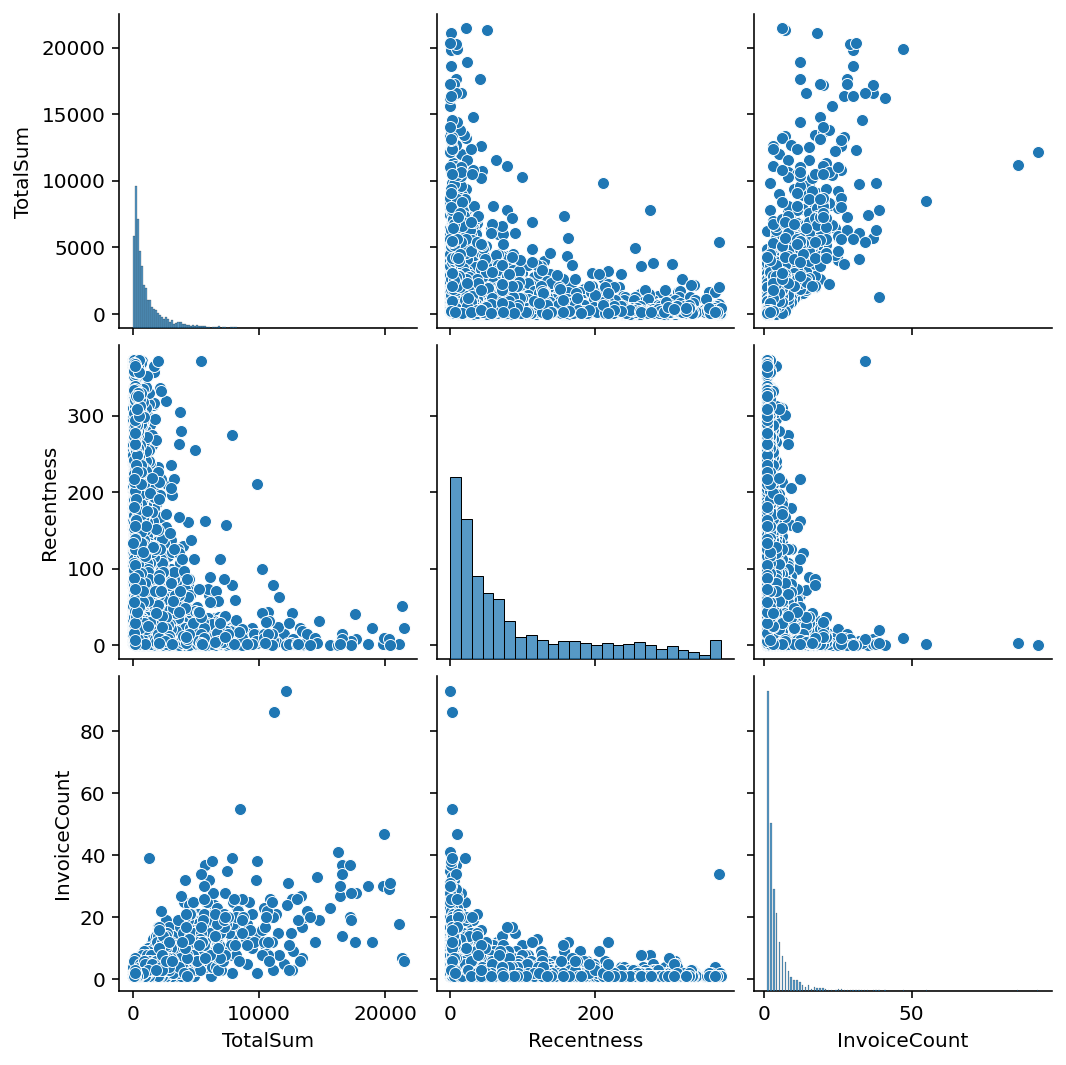

In [22]:
sns.pairplot(df_real)

## Normalization

For this dataset, I have experimented with not normalizing data and found that it can cluster better. So, I will not perform normalization.

---
# 1. K-Means Clustering
---

Use the Elbow Method to identify an appropriate K, where WCSS (Within-Cluster Sum of Squared) reduces sharply.

$$WCSS(k) = \sum_{j=1}^{k} \sum_{x \in cluster j} ||x_i - \bar{x}_j||^2$$  

<div align="center"> $x_i$: datapoint, $\bar{x}_j$: centroid in cluster $j$  

In [23]:
from sklearn.cluster import KMeans

In [24]:
df_real.sample(5)

TotalSum  Recentness  InvoiceCount
CustomerID                                    
17155.0       251.70          17             2
14870.0       327.25         261             1
12530.0      1662.28          59             4
14193.0       853.39          67             2
16996.0      1456.96          29             6

In [25]:
data = np.array(df_real)

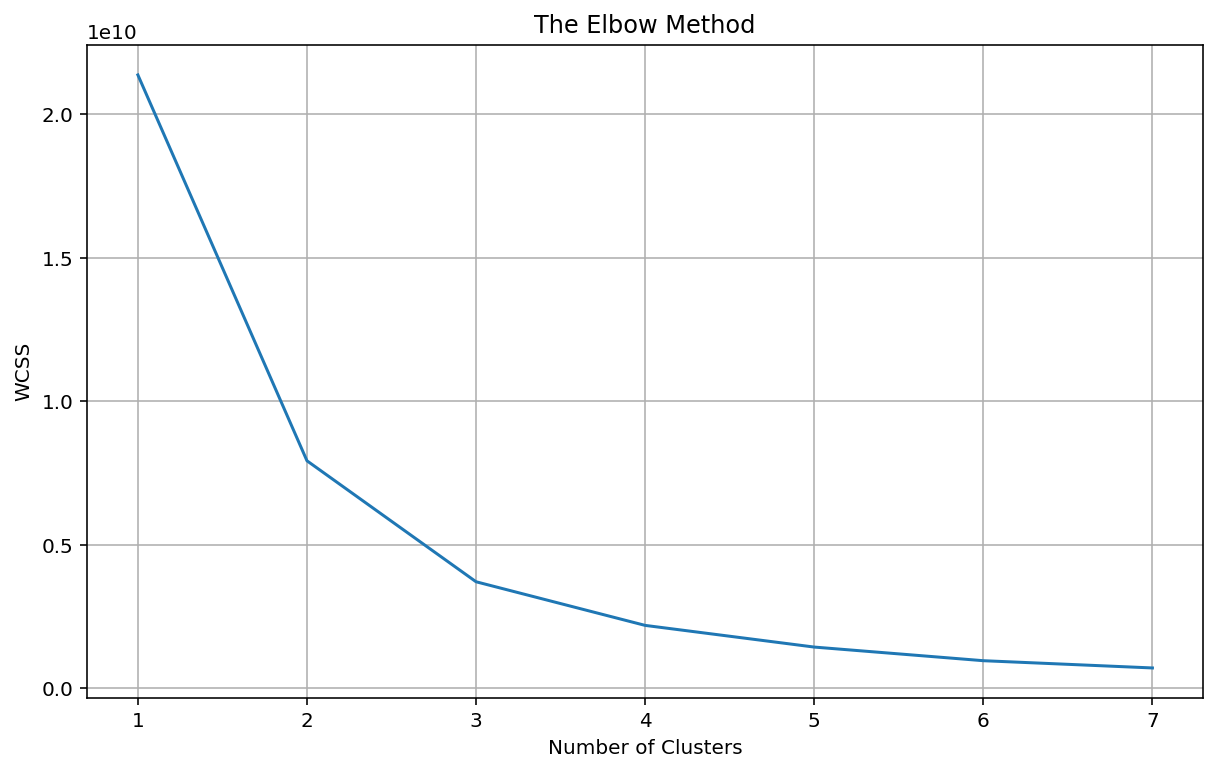

In [26]:
wcss = []

for i in range(1,8):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.plot(range(1,8), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid()

In [27]:
kmeans = KMeans(n_clusters=3, random_state=55)

In [28]:
kmeans_label = kmeans.fit_predict(data)

In [29]:
# Coordinates of centroids
kmeans.cluster_centers_

array([[7.11808746e+02, 1.04116653e+02, 2.55056802e+00],
       [1.27310578e+04, 1.47111111e+01, 2.03666667e+01],
       [4.10216891e+03, 3.16627907e+01, 9.48837209e+00]])

In [30]:
# WCSS (Within-Cluster Sum of Squared)
kmeans.inertia_

3716909651.445483

In [31]:
kmeans.n_iter_

4

## Clustering Visualization

### 3D Plot

In [32]:
x1 = data[kmeans_label == 0][:,0]
y1 = data[kmeans_label == 0][:,1]
z1 = data[kmeans_label == 0][:,2]

x2 = data[kmeans_label == 1][:,0]
y2 = data[kmeans_label == 1][:,1]
z2 = data[kmeans_label == 1][:,2]

x3 = data[kmeans_label == 2][:,0]
y3 = data[kmeans_label == 2][:,1]
z3 = data[kmeans_label == 2][:,2]

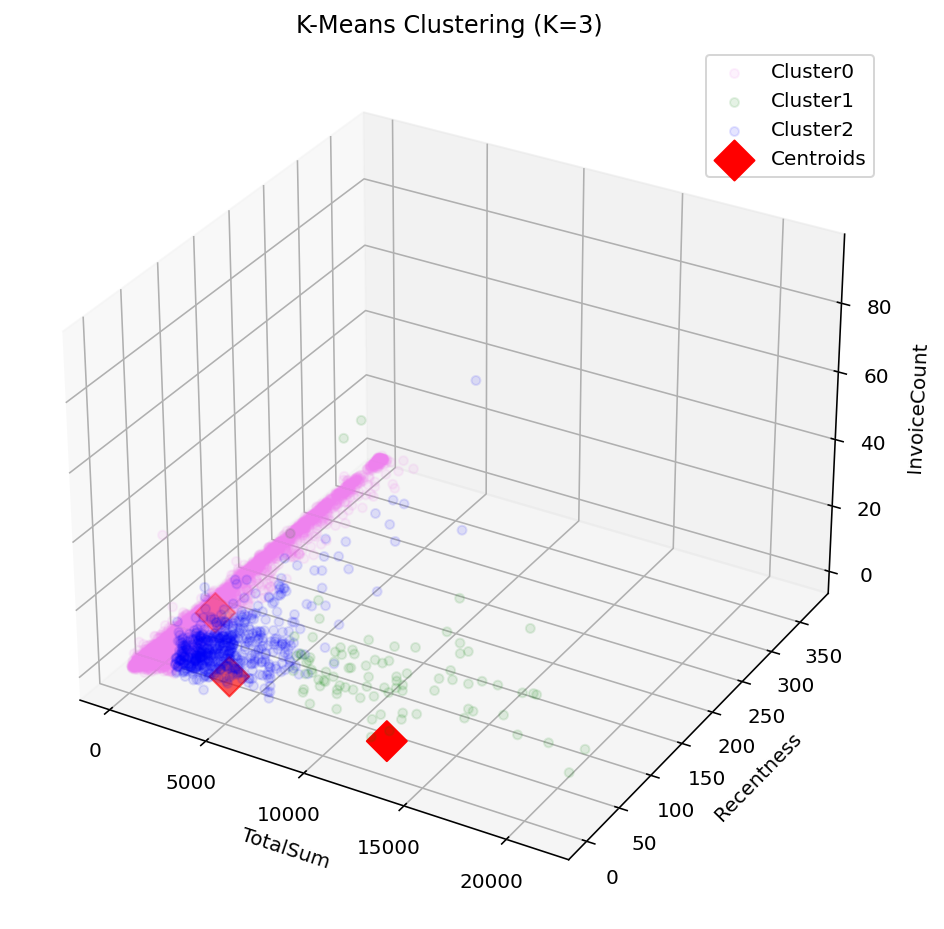

In [33]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')

ax.scatter(x1,y1,z1,c='violet',label='Cluster0', alpha=0.1)
ax.scatter(x2,y2,z2,c='green',label='Cluster1', alpha=0.1)
ax.scatter(x3,y3,z3,c='blue',label='Cluster2', alpha=0.1)

plt.scatter(kmeans.cluster_centers_[:,0],
            kmeans.cluster_centers_[:,1],
            s=200, c='red', label='Centroids', marker='D')

plt.title('K-Means Clustering (K=3)')
plt.xlabel('TotalSum')
plt.ylabel('Recentness')
ax.set_zlabel('InvoiceCount')

plt.legend()
plt.grid()

"TotalSum" represents the cumulative expense of customers.  

"Recentness" represents how many days have passed since the last time customers made a purchase.  

"InvoiceCount" represents the number of invoices purchased by customers. (The higher the value, the more purchases they have made.)

### 3D Interactive

In [34]:
df_new = df_real.copy()

In [35]:
df_new['Cluster'] = kmeans.labels_

In [36]:
my_dictionary = {0:'Cluster 0',1:'Cluster 1',2:'Cluster 2'}
df_new['Cluster'] = df_new['Cluster'].map(my_dictionary)

In [37]:
fig = px.scatter_3d(df_new,
              x='TotalSum',y='Recentness',z='InvoiceCount',
              color='Cluster')
fig.update_traces(marker_size=2)

![](./img/img1.png) 

### Barplot

Perform the normalization before plotting to ensure that all features are on the same scale for easier comparison.

In [38]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(df_new.iloc[:,:-1])

In [39]:
df_new_norm = pd.DataFrame(
    data = df_scaled, columns=df_new.iloc[:,:-1].columns
)
df_new_norm = pd.concat(
    [df_new_norm,df_new.reset_index().iloc[:,-1:]], axis=1
)

In [40]:
df_cluster_norm = df_new_norm.groupby('Cluster').mean()

In [41]:
df_cluster_norm

TotalSum  Recentness  InvoiceCount
Cluster                                      
Cluster 0  0.033195    0.279184      0.016856
Cluster 1  0.594093    0.039440      0.210507
Cluster 2  0.191296    0.084902      0.092130

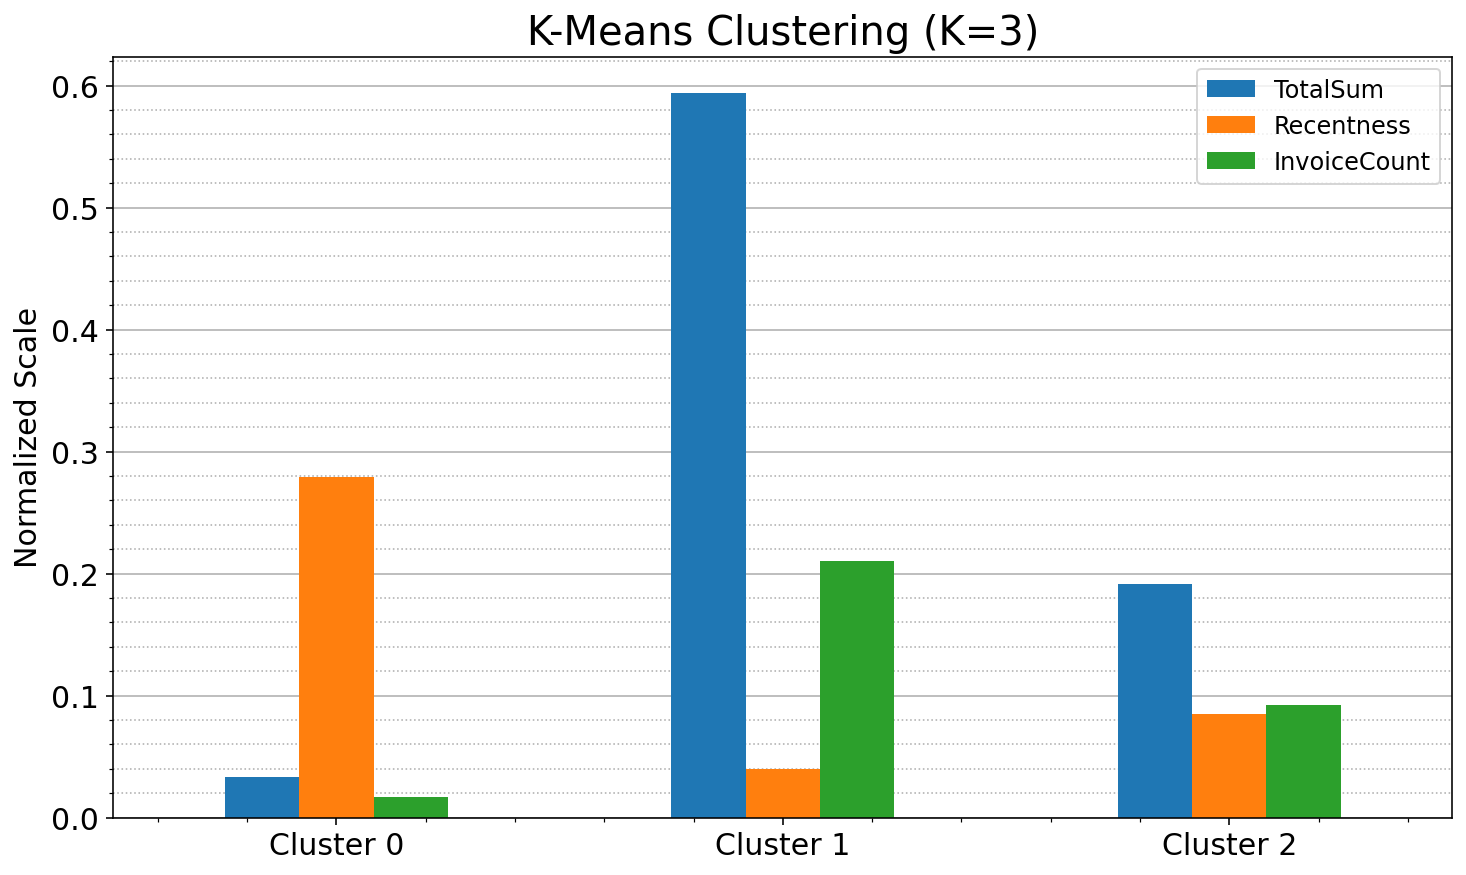

In [42]:
ax = df_cluster_norm.plot(
    kind='bar', rot=0,
    figsize = (12,7), fontsize=15
)
ax.set_axisbelow(True)
ax.grid(linestyle='-', axis='y')
ax.legend(fontsize=12, loc='best')

plt.minorticks_on()
plt.grid(which='minor', axis='y',ls=':')
plt.xlabel('')
plt.ylabel('Normalized Scale', fontsize=15)
plt.title('K-Means Clustering (K=3)', fontsize=20)
plt.show()

"TotalSum" represents the cumulative expense of customers.  

"Recentness" represents how many days have passed since the last time customers made a purchase.  

"InvoiceCount" represents the number of invoices purchased by customers. (The higher the value, the more purchases they have made.)

We can conclude that there are 3 clusters of customers.

| |Cluster 0 |Cluster 1 |Cluster 2 |
|:-:|:-:|:-:|:-:|
|**TotalSum**| Spend less| Spend more| Spend medium|
|**Recentness**| Long time| Recently| Recently|
|**InvoiceCount**| Buy less| Buy more|Buy somewhat|

---
# 2. Hierarchical Clustering
---

In [43]:
df_real.sample(5)

TotalSum  Recentness  InvoiceCount
CustomerID                                    
15865.0       895.13          40             3
16793.0       243.84          56             1
15083.0        88.20         256             1
14666.0       195.25          23             1
14854.0      2759.83          77             7

In [44]:
data = np.array(df_real)

In [45]:
import scipy.cluster.hierarchy as sch

In [ ]:
fig = plt.figure(figsize=(20,16))
dendrogram = sch.dendrogram(sch.linkage(data, method='ward'))
plt.title('Dendogram')
plt.xlabel('College')
plt.ylabel('Euclidean Distance')

plt.axhline(80000,0,1,color='k', ls='--',lw=3)
plt.text(1000,81000,'Threshold',size=25)

plt.savefig('./img/dendrogram')
plt.show()

![title](img/dendrogram.png)

Create the threshold line that,  

when combining the dendrogram's lines that cross the threshold line, the combined line will be the longest.

In this case, cluster=3.

In [46]:
from sklearn.cluster import AgglomerativeClustering

In [47]:
hc = AgglomerativeClustering(n_clusters=3)

In [48]:
y_hc = hc.fit_predict(data)

## Clustering Visualization

### 3D Plot

In [49]:
x1 = data[y_hc == 0][:,0]
y1 = data[y_hc == 0][:,1]
z1 = data[y_hc == 0][:,2]

x2 = data[y_hc == 1][:,0]
y2 = data[y_hc == 1][:,1]
z2 = data[y_hc == 1][:,2]

x3 = data[y_hc == 2][:,0]
y3 = data[y_hc == 2][:,1]
z3 = data[y_hc == 2][:,2]

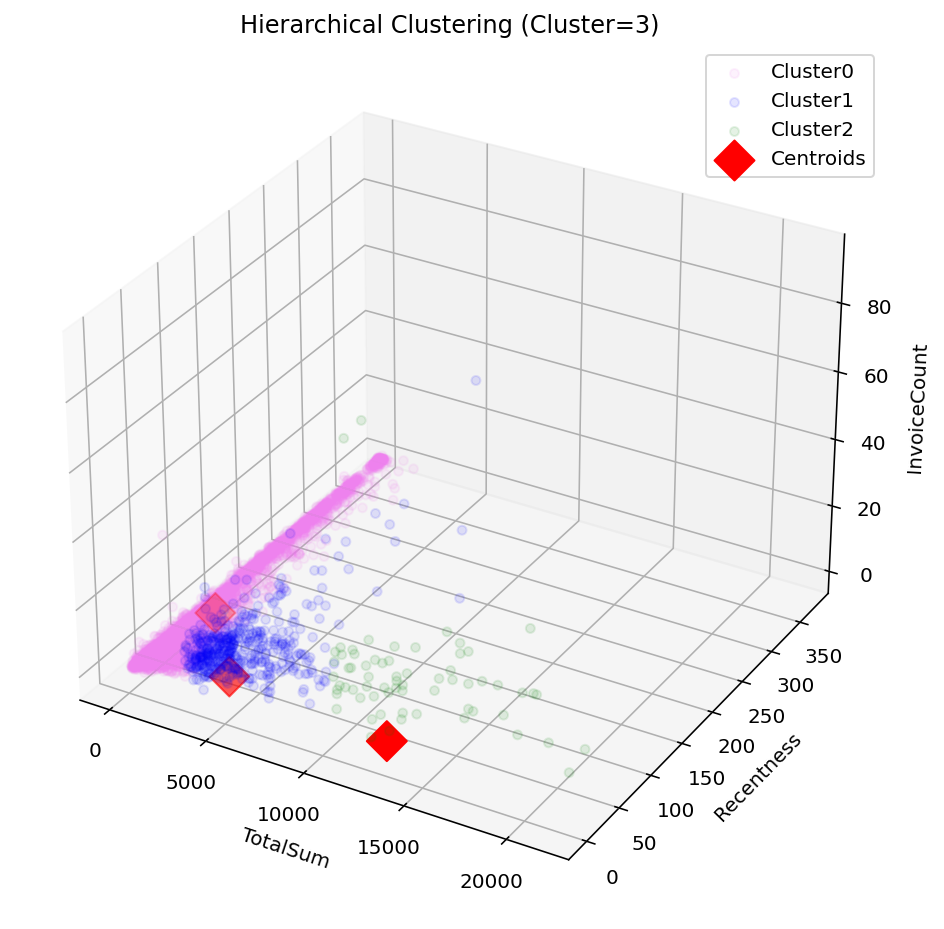

In [50]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')

ax.scatter(x1,y1,z1,c='violet',label='Cluster0', alpha=0.1)
ax.scatter(x2,y2,z2,c='blue',label='Cluster1', alpha=0.1)
ax.scatter(x3,y3,z3,c='green',label='Cluster2', alpha=0.1)

plt.scatter(kmeans.cluster_centers_[:,0],
            kmeans.cluster_centers_[:,1],
            s=200, c='red', label='Centroids', marker='D')

plt.title('Hierarchical Clustering (Cluster=3)')
plt.xlabel('TotalSum')
plt.ylabel('Recentness')
ax.set_zlabel('InvoiceCount')

plt.legend()
plt.grid()

Found that it has a similar result to K-Means.  
There are few data points that are clustered in the different clusters when compared to the K-Means.

### Barplot

Perform the normalization before plotting to ensure that all features are on the same scale for easier comparison.

In [51]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(df_new.iloc[:,:-1])

In [52]:
df_new_norm = pd.DataFrame(
    data = df_scaled, columns=df_new.iloc[:,:-1].columns
)
df_new_norm = pd.concat(
    [df_new_norm,df_new.reset_index().iloc[:,-1:]], axis=1
)

In [53]:
df_cluster_norm = df_new_norm.groupby('Cluster').mean()

In [54]:
df_cluster_norm

TotalSum  Recentness  InvoiceCount
Cluster                                      
Cluster 0  0.033195    0.279184      0.016856
Cluster 1  0.594093    0.039440      0.210507
Cluster 2  0.191296    0.084902      0.092130

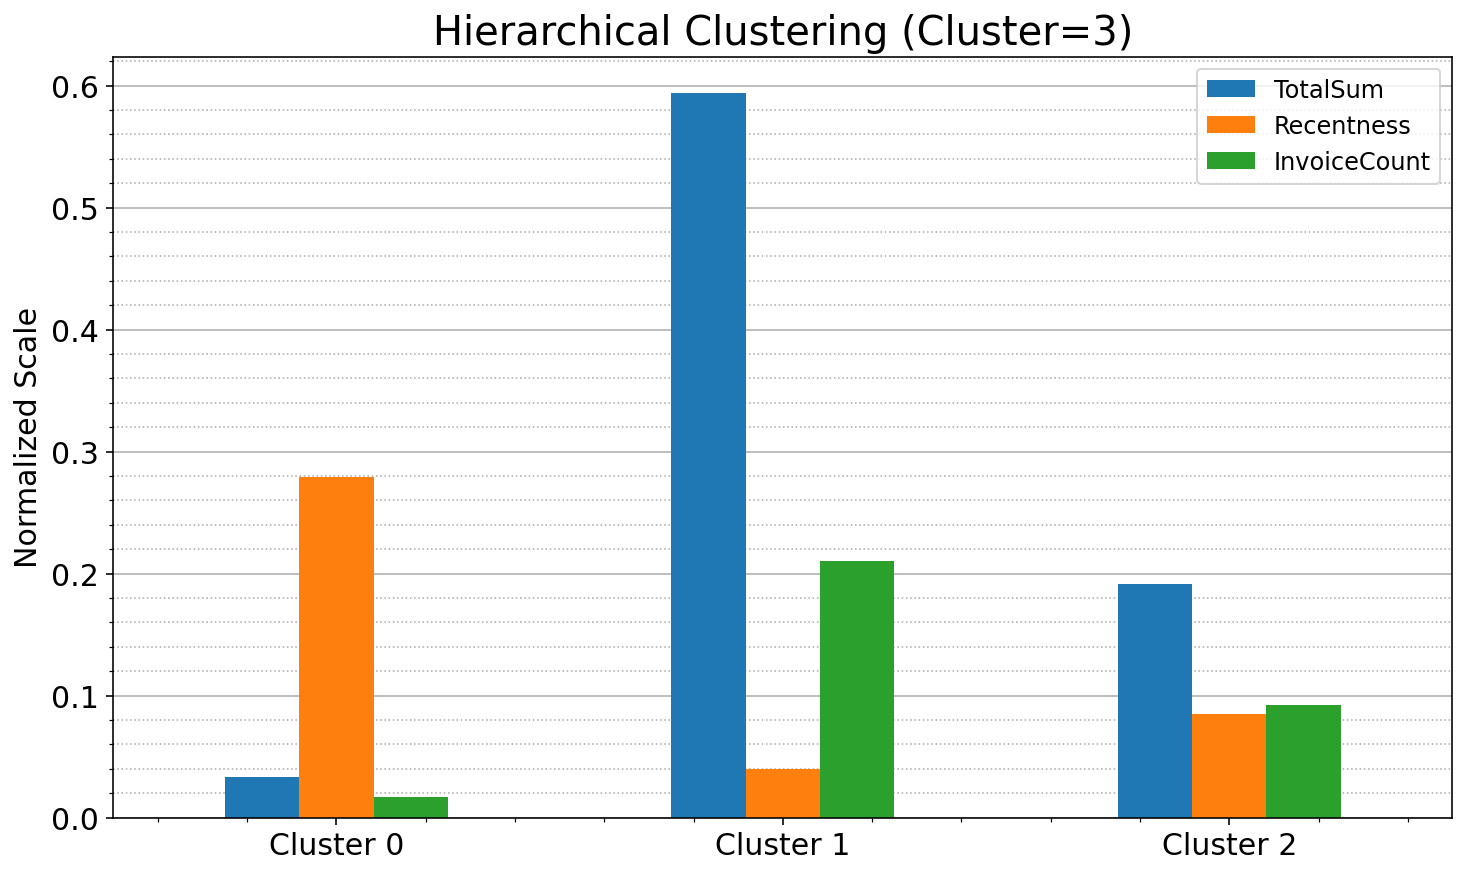

In [55]:
ax = df_cluster_norm.plot(
    kind='bar', rot=0,
    figsize = (12,7), fontsize=15
)
ax.set_axisbelow(True)
ax.grid(linestyle='-', axis='y')
ax.legend(fontsize=12, loc='best')

plt.minorticks_on()
plt.grid(which='minor', axis='y',ls=':')
plt.xlabel('')
plt.ylabel('Normalized Scale', fontsize=15)
plt.title('Hierarchical Clustering (Cluster=3)', fontsize=20)
plt.show()

Found that it has a similar result to K-Means.  
There are few data points that are clustered in the different clusters when compared to the K-Means.

---
# Thank You